In [1]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import ast
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, TOWNSHIP_NAME, VARIABLES, NORMALIZE_FLAGS, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-21 13:35:19,469 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
2025-01-21 13:35:19,469 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
2025-01-21 13:35:19,469 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


In [2]:

mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[["Features","m", "Indices"]]
motifs_sizes = mp_stats_table[["m"]].values.flatten().astype(int)
motifs_indexes = mp_stats_table[["Indices"]].values
motifs_indexes = [ast.literal_eval(item[0]) for item in motifs_indexes]


In [3]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_df

,,sum_terminals,sum_roaming_terminals,sum_phonecalls
one_time,township_name,,,
2021-09-15 00:00:00,Avenidas Novas,260700.0,17678.0,2262.0
2021-09-15 01:00:00,Avenidas Novas,276675.0,17533.0,994.0
2021-09-15 02:00:00,Avenidas Novas,284563.0,15280.0,725.0
2021-09-15 03:00:00,Avenidas Novas,279563.0,12424.0,393.0
2021-09-15 04:00:00,Avenidas Novas,281460.0,10789.0,290.0
...,...,...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0,12886.0,17569.0
2021-11-30 20:00:00,Avenidas Novas,352361.0,11026.0,13738.0
2021-11-30 21:00:00,Avenidas Novas,388246.0,13957.0,16368.0


In [4]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

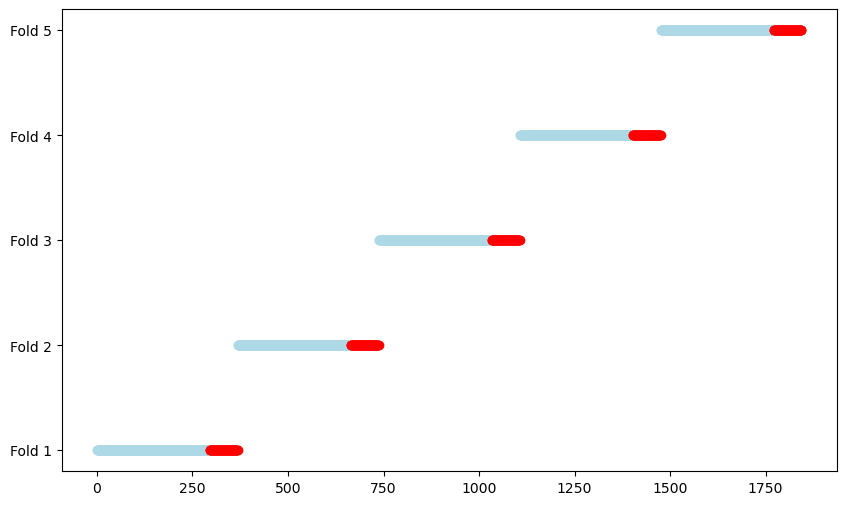

In [5]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [6]:
from utils.utils import create_multi_motif_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, X_mask, y = create_multi_motif_dataset(data, lookback_period, step, forecast_period, motifs_indexes, motifs_sizes)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([15676, 100, 3])
X_mask shape: torch.Size([15676, 100])
X_indices shape: torch.Size([15676, 8, 1])
y shape: torch.Size([15676, 1])


[I 2025-01-21 13:35:21,878] A new study created in memory with name: no-name-1f1d710c-d3fd-49a4-aa68-f45e7632c5b6


Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199


[I 2025-01-21 13:38:24,768] Trial 0 finished with value: 201.2179962158203 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 32}. Best is trial 0 with value: 201.2179962158203.


Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Early stopping at epoch 165, with best epoch being 154
Training completed all epochs. Best epoch was 199
Early stopping at epoch 185, with best epoch being 174


[I 2025-01-21 13:39:30,938] Trial 1 finished with value: 172.7603332519531 and parameters: {'learning_rate': 1.793578709982463e-05, 'num_layers': 1, 'batch_size': 128, 'hidden_size_layer_0': 256}. Best is trial 1 with value: 172.7603332519531.


Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Early stopping at epoch 112, with best epoch being 101
Training completed all epochs. Best epoch was 199
Early stopping at epoch 120, with best epoch being 109


[I 2025-01-21 13:40:04,177] Trial 2 finished with value: 171.72936401367187 and parameters: {'learning_rate': 7.653371871786874e-05, 'num_layers': 1, 'batch_size': 64, 'hidden_size_layer_0': 64}. Best is trial 2 with value: 171.72936401367187.


Training completed all epochs. Best epoch was 196
Early stopping at epoch 129, with best epoch being 118
Early stopping at epoch 134, with best epoch being 2
Early stopping at epoch 112, with best epoch being 12
Early stopping at epoch 121, with best epoch being 3


[I 2025-01-21 13:45:12,209] Trial 3 finished with value: 170.8138397216797 and parameters: {'learning_rate': 0.00011338007139562508, 'num_layers': 3, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 256}. Best is trial 3 with value: 170.8138397216797.


Early stopping at epoch 114, with best epoch being 76
Early stopping at epoch 120, with best epoch being 82
Early stopping at epoch 112, with best epoch being 19
Early stopping at epoch 127, with best epoch being 56
Early stopping at epoch 114, with best epoch being 22


[I 2025-01-21 13:47:34,606] Trial 4 finished with value: 171.66095581054688 and parameters: {'learning_rate': 6.5652023505944e-05, 'num_layers': 3, 'batch_size': 64, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 256}. Best is trial 3 with value: 170.8138397216797.


Early stopping at epoch 111, with best epoch being 95
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 196
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199


[I 2025-01-21 13:49:29,119] Trial 5 finished with value: 175.62240295410157 and parameters: {'learning_rate': 8.40991261739116e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 64}. Best is trial 3 with value: 170.8138397216797.


Training completed all epochs. Best epoch was 199
Early stopping at epoch 171, with best epoch being 160
Early stopping at epoch 111, with best epoch being 88
Early stopping at epoch 183, with best epoch being 172
Early stopping at epoch 111, with best epoch being 98


[I 2025-01-21 13:51:37,737] Trial 6 finished with value: 171.7222869873047 and parameters: {'learning_rate': 4.413013947169429e-05, 'num_layers': 3, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 64}. Best is trial 3 with value: 170.8138397216797.


Training completed all epochs. Best epoch was 192
Early stopping at epoch 114, with best epoch being 70
Early stopping at epoch 124, with best epoch being 8
Early stopping at epoch 119, with best epoch being 46
Early stopping at epoch 121, with best epoch being 8


[I 2025-01-21 13:52:44,562] Trial 7 finished with value: 171.60132751464843 and parameters: {'learning_rate': 0.0009678973008498044, 'num_layers': 3, 'batch_size': 64, 'hidden_size_layer_0': 128, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 64}. Best is trial 3 with value: 170.8138397216797.


Early stopping at epoch 115, with best epoch being 96
Training completed all epochs. Best epoch was 199
Early stopping at epoch 165, with best epoch being 154
Training completed all epochs. Best epoch was 199
Early stopping at epoch 182, with best epoch being 171


[I 2025-01-21 13:54:30,064] Trial 8 finished with value: 172.2690887451172 and parameters: {'learning_rate': 0.0001030062884451417, 'num_layers': 1, 'batch_size': 32, 'hidden_size_layer_0': 16}. Best is trial 3 with value: 170.8138397216797.


Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199
Training completed all epochs. Best epoch was 199


[I 2025-01-21 13:56:50,958] Trial 9 finished with value: 314.4402252197266 and parameters: {'learning_rate': 9.215336439857658e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 16}. Best is trial 3 with value: 170.8138397216797.


Training completed all epochs. Best epoch was 199
Best hyperparameters: {'learning_rate': 0.00011338007139562508, 'num_layers': 3, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 256}
Number of finished trials:  10
Best trial: 3
Best hyperparameters: {'learning_rate': 0.00011338007139562508, 'num_layers': 3, 'batch_size': 16, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 256}
Validation Losses: [185.681, 140.718, 178.538, 167.983, 181.15]
Mean validation loss: 170.814
Test Losses: [167.119, 182.344, 217.492, 200.636, 188.161]
Mean test loss: 191.15
Mean test MAE: 11.537 std: 0.74
Mean test RMSE: 13.812 std: 0.614


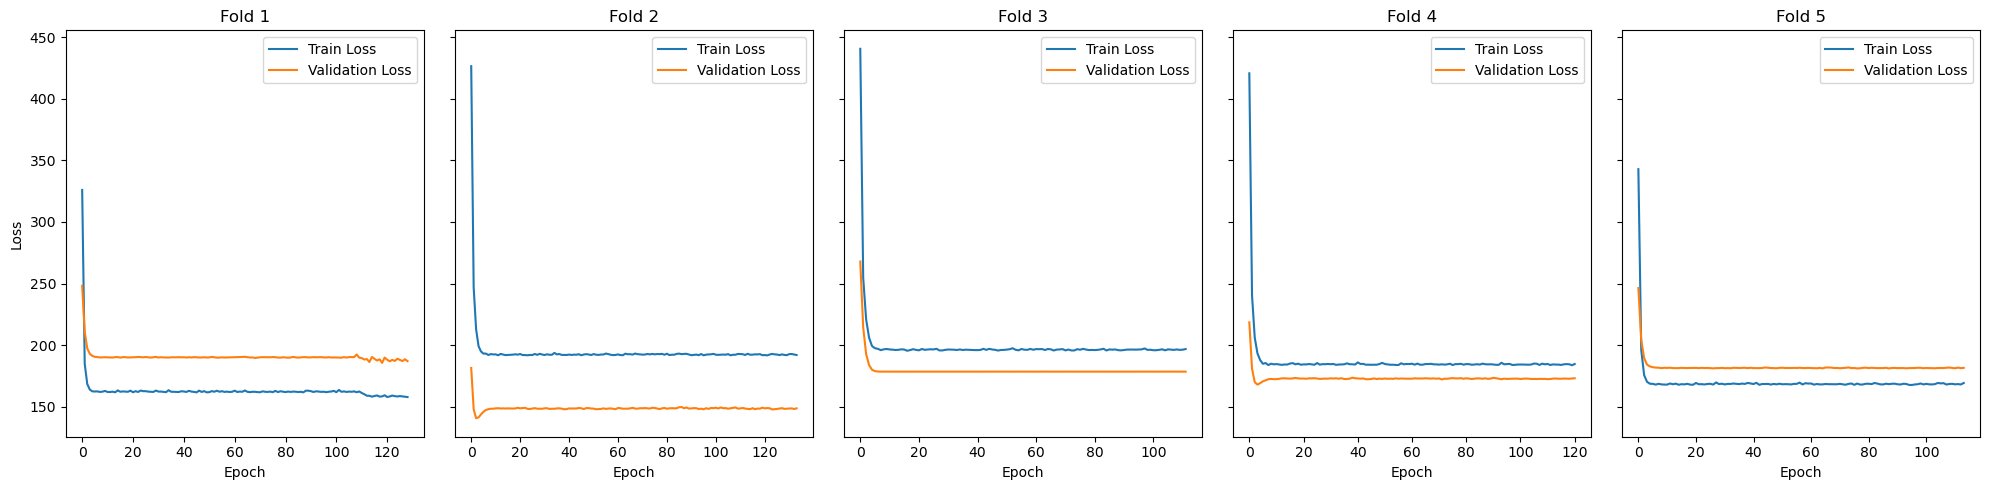

In [7]:
from models.lstm_pytorch import LSTM
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 3
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series}
run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


In [ ]:
from models.lstm_pytorch import LSTM
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 3
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series, "X_mask": X_mask}
run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


In [ ]:
from models.lstm_pytorch import LSTM
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results


n_trials = 3
num_epochs = 500
model_type = "LSTM"
model_name = "LSTMSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]  
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_indices": X_indices}
run_optuna_study(pipeline.run_cross_val, LSTM, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


[I 2025-01-21 14:02:44,061] A new study created in memory with name: no-name-5be2eec5-5f82-456c-b18a-efa3dd4b29dd


Early stopping at epoch 494, with best epoch being 483
Early stopping at epoch 288, with best epoch being 277
Training completed all epochs. Best epoch was 498
Early stopping at epoch 338, with best epoch being 327
